Tutorial from: https://www.geeksforgeeks.org/multiclass-image-classification-using-transfer-learning/ 

Aim: Use ML to predict the grade of diabetic retinopathy from a fundus image. Therefore a multi-class image classification problem. Solved by using a pre-trained model, and customizing it.

InceptionResNetV2: is a convolutional neural network that is 164 layers deep, trained on millions of images from the ImageNet database, and can classify images into more than 1000 categories such as flowers, animals, etc. The input size of the images is 299-by-299.

Necessities for transfer learning: Low-level features from model A (task A) should be helpful for learning model B (task B).

# Imports

In [14]:
# Import

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import cv2

# deep learning libraries
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB3, ResNet50, VGG16, InceptionV3, MobileNet, Xception

# Define the input shape based on the model's requirements
InceptionV3_input_shape = (299, 299, 3)  # InceptionV3 requires (299, 299, 3) input shape

import warnings
warnings.filterwarnings('ignore')


# Environment set up

In [15]:
# Set up
# Run extract_data.ipynb first

data_path = './data/UoA-DR/' 
train_path = os.path.join(data_path, 'train')
test_path = os.path.join(data_path, "test") 
label_path = os.path.join(data_path, 'UoA-DR-labels.csv')

labels = pd.read_csv(label_path)

x_name = "image number"
y_name = "class"

possible_labels = sorted(labels[y_name].unique())
print(possible_labels)

labels.head()

['healthy', 'npdr', 'pdr']


,image number,class,healthy,npdr,pdr
0,1,npdr,0,1,0
1,2,npdr,0,1,0
2,3,npdr,0,1,0
3,4,npdr,0,1,0
4,5,npdr,0,1,0


In [16]:
# Custom function to convert image number to file path with JPG extension

extension = ".jpg"

def to_file_path(id):
    return os.path.join(labels[labels[x_name] == id][y_name].values[0], id + extension)

def to_jpg(id):
    return str(id) + ".jpg"

# Apply the to_file_path function if the folder is sorted by class, otherwise apply the to_jpg function
if len(os.listdir(os.path.join(train_path))) > 1 and len(os.listdir(os.path.join(test_path))) > 1:
    conversion = to_file_path
elif len(os.listdir(os.path.join(train_path))) == 0 and len(os.listdir(os.path.join(test_path))) == 0:
    conversion = to_jpg
else:
    print("Error with training and testing file sizes")
    
labels[x_name] = labels[x_name].astype(str)
labels[x_name] = labels[x_name].apply(conversion)

labels.head()

,image number,class,healthy,npdr,pdr
0,npdr/1.jpg,npdr,0,1,0
1,npdr/2.jpg,npdr,0,1,0
2,npdr/3.jpg,npdr,0,1,0
3,npdr/4.jpg,npdr,0,1,0
4,npdr/5.jpg,npdr,0,1,0


# Data agumentation and pre-processing

In [17]:
# Data agumentation and pre-processing

rescale_factor = 1./255.
has_horizontal_flip = True
validation_split = 0.2 # training: 80% data, validation: 20% data
batch_size = 32
has_shuffle = True
seed = 49
image_size = (331, 331) # image height , image width

gen = ImageDataGenerator( # TODO add rotation_range=30 or zoom_range=0.4??
				rescale= rescale_factor,
				horizontal_flip = has_horizontal_flip,
				validation_split= validation_split 
				)

train_generator = gen.flow_from_dataframe(
	labels, # dataframe
	directory = train_path, # images data path / folder in which images are there
	x_col = x_name,
	y_col = y_name,
	subset="training",
	color_mode="rgb",
	target_size = image_size, 
	class_mode="categorical",
	batch_size=batch_size,
	shuffle=has_shuffle,
	seed=seed,
)


validation_generator = gen.flow_from_dataframe(
	labels, # dataframe
	directory = test_path, # images data path / folder in which images are there
	x_col = x_name,
	y_col = y_name,
	subset="validation",
	color_mode="rgb",
	target_size = image_size,
	class_mode="categorical",
	batch_size=batch_size,
	shuffle=has_shuffle,
	seed=seed,
)

x,y = next(train_generator)
x.shape # input shape of one record is (331,331,3)

Found 135 validated image filenames belonging to 3 classes.
Found 6 validated image filenames belonging to 3 classes.


(32, 331, 331, 3)

# Plot input images

class_names is ['healthy', 'npdr', 'pdr']


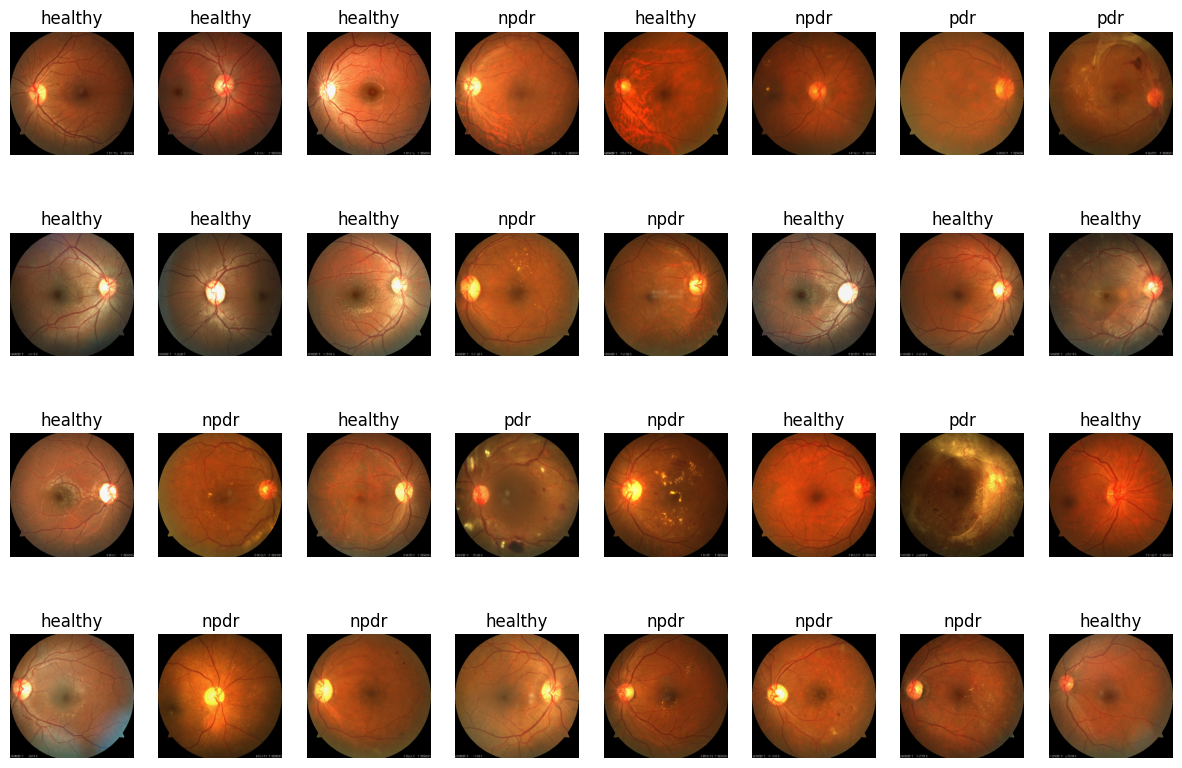

In [20]:
# Plot images

class_names = list(train_generator.class_indices.keys()) # storing class names in a list
print("class_names is", class_names)

def plot_images_with_numbers(x, y):
    plt.figure(figsize=[15, 10])
    for i in range(batch_size):
        plt.subplot(4, 8, i+1)
        plt.imshow(x[i])
        label = class_names[np.argmax(y[i])]
        plt.title(f"{label}")
        plt.axis('off')

plot_images_with_numbers(x, y) 

# Experiment with different pre-trained models

In [21]:
# Define a function to create and compile models with different architectures
def create_model(base_model, input_shape, num_classes):
    base_model.trainable = False # Freeze the pre-trained layers
    model = tf.keras.Sequential([
        base_model,
        BatchNormalization(renorm=True), #normalize the activations
        GlobalAveragePooling2D(), # reduce spatial dimensions.
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dropout(0.5), # prevent overfitting.
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [22]:
# Experiment with different base models

base_models = {
    "EfficientNetB3": EfficientNetB3(input_shape=(331, 331, 3), include_top=False, weights='imagenet'),
    "ResNet50": ResNet50(input_shape=(331, 331, 3), include_top=False, weights='imagenet'),
    "VGG16": VGG16(input_shape=(331, 331, 3), include_top=False, weights='imagenet'),
    "InceptionV3": InceptionV3(input_shape=InceptionV3_input_shape, include_top=False, weights='imagenet'),
    "MobileNet": MobileNet(input_shape=(331, 331, 3), include_top=False, weights='imagenet'),
    "Xception": Xception(input_shape=(331, 331, 3), include_top=False, weights='imagenet'),
    # Add other models here

}

results = {}

for model_name, base_model in base_models.items():
    model = create_model(base_model, (331, 331, 3), num_classes=3)
    
    # Define early stopping callback to monitor the 'accuracy' metric and prevent overfitting.
    # Training is stopped early if the accuracy doesn't improve after a certain number of epochs (controlled by patience)
    early = EarlyStopping(patience=10, min_delta=0.001, restore_best_weights=True, monitor='accuracy')
    
    # Fit the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.n // train_generator.batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.n // validation_generator.batch_size,
        epochs=25,
        callbacks=[early]
    )
    
    # Save or analyze the model and its performance
    # Store the results in the dictionary
    results[model_name] = {
        "model": model,
        "history": history.history
    }


print(results)

Epoch 1/25


2023-10-17 20:45:52.835327: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1fa2c0b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-17 20:45:52.835350: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2023-10-17 20:45:54.075974: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-17 20:45:56.523284: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 [==============================] - 15s 1s/step - loss: 1.2331 - accuracy: 0.3204
Epoch 2/25
4/4 [==============================] - 3s 819ms/step - loss: 1.0734 - accuracy: 0.4297
Epoch 3/25
4/4 [==============================] - 3s 555ms/step - loss: 1.0777 - accuracy: 0.4854
Epoch 4/25
4/4 [==============================] - 3s 553ms/step - loss: 1.1847 - accuracy: 0.2621
Epoch 5/25
4/4 [==============================] - 3s 542ms/step - loss: 1.0757 - accuracy: 0.3981
Epoch 6/25
4/4 [==============================] - 3s 588ms/step - loss: 1.0596 - accuracy: 0.5049
Epoch 7/25
4/4 [==============================] - 3s 574ms/step - loss: 1.0898 - accuracy: 0.3592
Epoch 8/25
4/4 [==============================] - 3s 815ms/step - loss: 1.0855 - accuracy: 0.3689
Epoch 9/25
4/4 [==============================] - 3s 767ms/step - loss: 1.0913 - accuracy: 0.3984
Epoch 10/25
4/4 [==============================] - 3s 590ms/step - loss: 1.0782 - accuracy: 0.3786
Epoch 11/25
4/4 [===============

2023-10-17 20:48:00.810022: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.69GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-10-17 20:48:00.810065: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.69GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-10-17 20:48:00.851136: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.69GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-10-17 20:48:00.851168: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU

4/4 [==============================] - 4s 302ms/step - loss: 1.0867 - accuracy: 0.4369
Epoch 2/25
4/4 [==============================] - 3s 827ms/step - loss: 1.0744 - accuracy: 0.3981
Epoch 3/25
4/4 [==============================] - 3s 538ms/step - loss: 1.0707 - accuracy: 0.4078
Epoch 4/25
4/4 [==============================] - 4s 847ms/step - loss: 1.0259 - accuracy: 0.5078
Epoch 5/25
4/4 [==============================] - 3s 591ms/step - loss: 1.0656 - accuracy: 0.4466
Epoch 6/25
4/4 [==============================] - 3s 596ms/step - loss: 0.9822 - accuracy: 0.4951
Epoch 7/25
4/4 [==============================] - 3s 649ms/step - loss: 1.0377 - accuracy: 0.4757
Epoch 8/25
4/4 [==============================] - 3s 810ms/step - loss: 0.9948 - accuracy: 0.5156
Epoch 9/25
4/4 [==============================] - 3s 591ms/step - loss: 0.9509 - accuracy: 0.5922
Epoch 10/25
4/4 [==============================] - 3s 818ms/step - loss: 0.9634 - accuracy: 0.5728
Epoch 11/25
4/4 [=============

# Evaluation of each model

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

# FYI data structure is as
# results[model_name] = {
#     "model": model,
#     "history": history.history
# }

for model_name, data in results.items():
    model = data["model"]
    history = data["history"]
    
    predictions = model.predict(validation_generator)
    true_labels = validation_generator.labels
    predicted_classes = predictions.argmax(axis=1)

    # Calculate precision, recall, and F1 score
    report = classification_report(true_labels, predicted_classes)
    confusion = confusion_matrix(true_labels, predicted_classes)

    print(f"Metrics for {model_name}:\n")
    for measurement_name, measurements in history.items():
        print(measurement_name, "max measurements:", max(measurements))
    # print(f"Confusion Matrix:\n{confusion}\n")
    print(f"Classification Report:\n{report}\n")


1/1 [==============================] - 1s 1s/step
Metrics for EfficientNetB3:

loss max measurements: 1.233102560043335
accuracy max measurements: 0.5048543810844421
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         6

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6


1/1 [==============================] - 1s 989ms/step
Metrics for ResNet50:

loss max measurements: 1.27406907081604
accuracy max measurements: 0.4660194218158722
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         6

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6


1/1 [==============================] - 1s 584ms/step
Metrics for VGG16:

loss 

# Plot accuracy vs loss

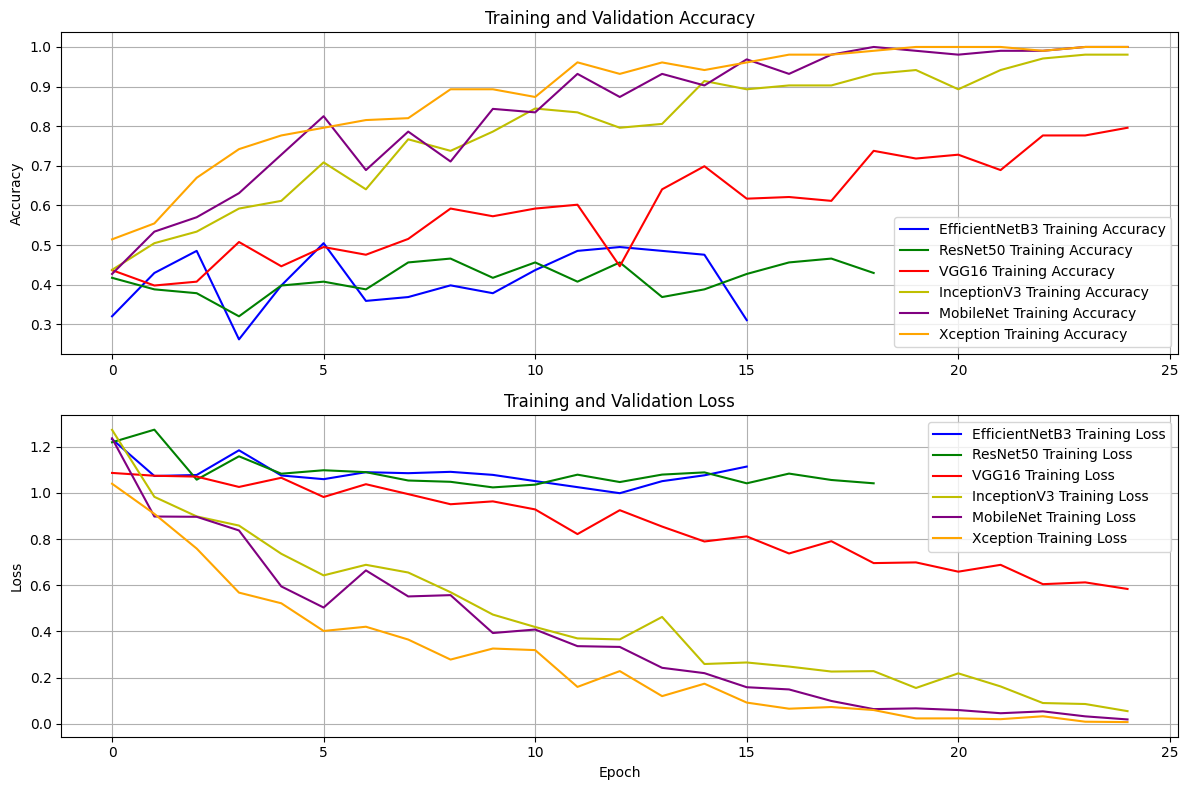

In [24]:
import matplotlib.pyplot as plt

colors = ['b', 'g', 'r', 'y', 'purple', 'orange']
plt.figure(figsize=(12, 8))

# Plot accuracy curves for each model
plt.subplot(2, 1, 1)
for idx, (model_name, data) in enumerate(results.items()):
    history = data["history"]
    acc = history["accuracy"]
    plt.plot(acc, label=f'{model_name} Training Accuracy', color=colors[idx])

plt.legend()
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid(True)

# Plot loss curves for each model
plt.subplot(2, 1, 2)
for idx, (model_name, data) in enumerate(results.items()):
    history = data["history"]
    loss = history["loss"]
    plt.plot(loss, label=f'{model_name} Training Loss', color=colors[idx])

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid(True)

plt.tight_layout()
plt.show()


In [25]:
# Evaluate model

print(model)
accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))
print("Loss: ",accuracy_score[0])


1/1 [==============================] - 1s 567ms/step - loss: 0.2387 - accuracy: 0.8333
[0.23867817223072052, 0.8333333134651184]
Accuracy: 83.3333%
Loss:  0.23867817223072052


# Test

1/1 [==============================] - 0s 13ms/step
Prediction: [[0.13571195 0.01151871 0.8527693 ]]
Labels: ['healthy', 'npdr', 'pdr']
Predicted class: pdr


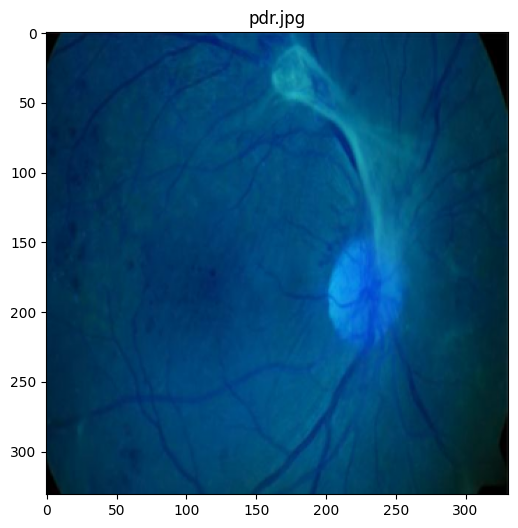

In [37]:
# Testing

# test_img_path = os.path.join(test_path, "healthy/105.jpg")
test_img_path = os.path.join("pdr.jpg")
img = cv2.imread(test_img_path)
resized_img = cv2.resize(img, (331, 331)).reshape(-1, 331, 331, 3)/255
 
plt.figure(figsize=(6,6))
plt.title(test_img_path)
plt.imshow(resized_img[0])


img = tf.keras.preprocessing.image.load_img(test_img_path)
img = tf.keras.preprocessing.image.img_to_array(img)
img = tf.keras.preprocessing.image.smart_resize(img, (331, 331))
img = tf.reshape(img, (-1, 331, 331, 3))
prediction = model.predict(img/255)

print("Prediction:", prediction)

# Get the index of the class with the highest probability
predicted_class_index = np.argmax(prediction)

print("Labels:", possible_labels)
print("Predicted class:", possible_labels[predicted_class_index])



# Save model

In [31]:
# Save model

model.save("models/1710.h5")
